In [119]:
#Imports
from time import time
import pandas as pd
pd.set_option("max.colwidth", 500)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD, NMF
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from textblob import TextBlob

In [120]:
# Read in data:

df = pd.read_csv("/Users/Darrenklee/Desktop/DS-Project/LoanStats3d.csv")

In [121]:
#pass in new subset of features

good_feat = ["num_tl_120dpd_2m",
"mo_sin_old_il_acct",
"percent_bc_gt_75",
"bc_util",
"bc_open_to_buy",
"dti",
"num_rev_accts",
"delinq_2yrs",
"inq_last_6mths",
"revol_bal",
"open_acc",
"pub_rec",
"total_acc",
"num_bc_tl",
"funded_amnt",
"int_rate",
"installment",
"home_ownership",
"annual_inc",
"total_rec_int",
"chargeoff_within_12_mths",
"num_sats",
"num_rev_tl_bal_gt_0",
"total_rev_hi_lim",
"num_op_rev_tl",
"num_il_tl",
"acc_open_past_24mths",
"avg_cur_bal",
"delinq_amnt",
"num_tl_90g_dpd_24m",
"mo_sin_old_rev_tl_op",
"mo_sin_rcnt_rev_tl_op",
"mo_sin_rcnt_tl",
"mort_acc",
"num_accts_ever_120_pd",
"num_actv_bc_tl",
"num_actv_rev_tl",
"num_tl_30dpd",
"num_tl_op_past_12m",
"total_il_high_credit_limit",
"num_bc_sats",
"collections_12_mths_ex_med",
"policy_code",
"total_bc_limit",
"pct_tl_nvr_dlq",
"total_bal_ex_mort",
"acc_now_delinq",
"tot_coll_amt",
"tot_cur_bal",
"tot_hi_cred_lim",
"tax_liens",
"pub_rec_bankruptcies",
"loan_amnt",
"total_pymnt",            
"revol_util",
"term",
"purpose",
"emp_length",
'loan_status',
'application_type',
'grade',
"emp_title"]



#manually removed:
#"recoveries", , "hardship_flag", "title", "total_rec_late_fee",
#"funded_amnt_inv", "issue_d", "verification_status", "grade", "sub_grade", "initial_list_status",
#"pymnt_plan", "debt_settlement_flag", "addr_state", "earliest_cr_line",
#"mths_since_recent_bc", "total_rec_prncp", "total_pymnt_inv", "out_prncp_inv",
#'last_pymnt_amnt','collection_recovery_fee','total_pymnt', "out_prncp", "last_credit_pull_d"

#drop:
#'sub_grade', 'verification_status', 'issue_d', 'pymnt_plan',  'title','zip_code','addr_state',
# 'earliest_cr_line',  'initial_list_status',  'last_pymnt_d', 'next_pymnt_d', 'desc',
#'verification_status_joint', 'hardship_flag','hardship_type','hardship_reason','hardship_status','
#hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_loan_status',
#'disbursement_method','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date'

#categorical(included in [good_feat]): will transform to dummies in df_fe function.
#"last_pymnt_d",
#'term','emp_length','home_ownership',
#'purpose', 'application_type'

# save for NLP if possible: 
# "emp_title"

In [123]:
#Create a function that will take unclean data, and apply feature engineering techniques

df = pd.read_csv("/Users/Darrenklee/Desktop/DS-Project/LoanStats3d.csv")
#good_feat eliminates all null columns
df = df[good_feat]
#we only want to focus on "Fully Paid" and "Charged Off" loans as target
df = df[df.loan_status != "Current"]
df = df[df.loan_status != "Late (31-120 days)"]
df = df[df.loan_status != "In Grace Period"]
df = df[df.loan_status != "Late (16-30 days)"]
df = df[df.loan_status != "Default"]
df = df[df.application_type != "Joint App"]
#0 for Fully Paid loans, and 1 for Charged Off loans
target_dict = {"Fully Paid":0, "Charged Off":1}
df["loan_status"] = df.loan_status.map(target_dict)

def length_decider(x):
    if x == "36 months":
        return 36
    else:
        return 60
    
def df_fe(df):
    df.dropna(inplace= True)
    df.drop("application_type", axis=1, inplace =True)
    #df.term = df.term.apply(length_decider)
    #df["term"] = df.term.astype(int)
    df["term"] = df.term.str.replace(" months", "")  
    df["term"] = df.term.astype(float)
    df["int_rate"] = df.int_rate.str.replace("%", "")  
    df["int_rate"] = df.int_rate.astype(float)
    df["revol_util"] = df.revol_util.str.replace("%", "")  
    df["revol_util"] = df.revol_util.astype(float)
    #create dummy variables for categorical data
    df_purpose_dums = pd.get_dummies(df.purpose, prefix = "purpose", drop_first=True)
    df = pd.concat([df, df_purpose_dums], axis = 1)
    df.drop("purpose", axis = 1, inplace=True)
    #df_term_dums = pd.get_dummies(df.term, prefix = "term", drop_first = True)
    #df = pd.concat([df, df_term_dums], axis = 1)
    #df.drop("term", axis = 1, inplace=True)
    df_emp_length_dums = pd.get_dummies(df.emp_length, prefix = "emp_length", drop_first = True)
    df = pd.concat([df, df_emp_length_dums], axis = 1)
    df.drop("emp_length", axis = 1, inplace=True)
    df_ownership_dums = pd.get_dummies(df.home_ownership, prefix = "ownership", drop_first = True)
    df = pd.concat([df, df_ownership_dums], axis = 1)
    df.drop("home_ownership", axis = 1, inplace=True)
    df.columns = df.columns.str.lower()
    #df.columns = df.columns.str.replace(" ", "_")
    #df.columns = df.columns.str.replace("-", "_")
    #df.columns = df.columns.str.replace("__", "_")
    #fico has high and low range columns, take average!
    #df["fico_average"] = df[["fico_high_range", "fico_low_range"]].mean(axis=1)
    return df

In [124]:
lcdf = df_fe(df)

In [125]:
grade_classes = lcdf.grade
lcdf.drop("grade", axis = 1, inplace= True)

In [126]:
lcdf.shape

(183660, 83)

In [127]:
lcdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183660 entries, 1 to 421094
Data columns (total 83 columns):
num_tl_120dpd_2m              183660 non-null float64
mo_sin_old_il_acct            183660 non-null float64
percent_bc_gt_75              183660 non-null float64
bc_util                       183660 non-null float64
bc_open_to_buy                183660 non-null float64
dti                           183660 non-null float64
num_rev_accts                 183660 non-null float64
delinq_2yrs                   183660 non-null int64
inq_last_6mths                183660 non-null int64
revol_bal                     183660 non-null int64
open_acc                      183660 non-null int64
pub_rec                       183660 non-null int64
total_acc                     183660 non-null int64
num_bc_tl                     183660 non-null int64
funded_amnt                   183660 non-null int64
int_rate                      183660 non-null float64
installment                   183660 non-

In [129]:
lcdf.term.tail()

421088    36.0
421089    36.0
421092    60.0
421093    60.0
421094    36.0
Name: term, dtype: float64

# Did not use NLP in this section. Word2Vec was used in H2o.ai to generate a word vector (100 columns) over the dataset 
[skip to k-means section]

In [9]:
df_nlp = lcdf

In [10]:
X = df_nlp[["emp_title", "loan_status"]]

In [11]:
X.head()

,emp_title,loan_status
1,Emergency Department technician,0
7,Corporate Insurance,0
9,Teacher,0
10,Regional Sales Direcdtor,1
15,hvac technician,1


In [14]:
X.shape

(183660, 2)

In [13]:
X.to_csv("emp_title_loan_status_data.csv")

In [32]:
# define a function that accepts text and returns a list of lemons (noun version)

def word_tokenize_lemma(emp_title):
    words = TextBlob(emp_title).words
    return [word.lemmatize() for word in words]

# define a function that accepts text and returns a list of lemons (verb version)
def word_tokenize_lemma_verb(emp_title):
    words = TextBlob(emp_title).words
    return [word.lemmatize(pos = "v") for word in words]

In [14]:
def text_model_evaluator(vect):
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    print "Features: ", X_train_dtm.shape[1]
    print "Training Score: ", nb.score(X_train_dtm, y_train)
    print "Testing Score: ", nb.score(X_test_dtm, y_test)

In [144]:
# define X and y
X = df_nlp.emp_title.sample(10000, random_state=120)
y = df_nlp.loan_status.sample(10000, random_state=120)
#Null accuracy
print y.value_counts(normalize=True)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=1)

0    0.7455
1    0.2545
Name: loan_status, dtype: float64


In [145]:
#Intialize vectorizer with default settings
vect = TfidfVectorizer(analyzer= word_tokenize_lemma_verb, binary= False, stop_words= 'english', 
                       lowercase= True, ngram_range = (1,1), decode_error = "none")
#Fit and transform X
X_dtm = vect.fit_transform(X)

#Intialize, fit, and score model on training data
nb = MultinomialNB()
nb.fit(X_dtm, y)

nb.score(X_dtm, y)

0.78620000000000001

In [334]:
features = vect.get_feature_names()

In [335]:
features[-5:]

['cluster_dist', 'emp_title']

# K-means Clustering

Used h2o.ai Word2Vec package to tokenize and create vectors of 100 columns for each emp_title. What you see if df2 is the output from:

https://github.com/darrenklee79/DS-SF-40/blob/master/NLP_Word2Vec.ipynb

In [131]:
from sklearn.cluster import KMeans

In [130]:
df2 = pd.read_csv("/Users/Darrenklee/Desktop/data.csv")
df2.shape

(183660, 102)

In [132]:
df2.fillna(0, inplace= True)
df2.shape

(183660, 102)

In [16]:
# df2.set_index("emp_title", inplace = True)

In [133]:
df2.head()

,emp_title,loan_status,C1,C2,C3,C4,C5,C6,C7,C8,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0,Emergency Department technician,0,-0.237751,-0.072932,0.089499,-0.139048,-0.182811,0.239338,0.009414,0.082465,...,0.026328,-0.081934,0.093037,-0.240905,-0.090011,0.063756,-0.258116,-0.550784,-0.072068,0.314838
1,Corporate Insurance,0,0.136679,-0.144567,-0.219635,0.176496,0.058962,0.115669,0.095650,0.240872,...,0.009625,-0.216761,-0.132466,0.086935,0.115855,-0.268649,-0.298816,0.186870,0.140972,0.203839
2,Teacher,0,-0.420405,0.337638,-0.041865,-0.713847,-0.550960,0.108866,0.171319,-0.330193,...,0.520902,0.334120,-0.838555,0.173891,-0.727107,-0.246951,-0.474045,-0.059159,0.952233,0.324939
3,Regional Sales Direcdtor,1,0.398176,0.071623,-0.295504,0.082468,0.415381,-0.258422,0.184185,-0.073800,...,-0.092683,-0.258902,-0.012370,-0.316318,0.367773,0.035674,0.075773,0.139615,0.108686,0.422246
4,hvac technician,1,-0.212824,-0.113866,0.238909,0.357511,-0.287052,-0.008327,0.352402,0.099435,...,-0.184388,0.122519,0.265062,-0.325889,-0.064289,0.019013,0.093237,-0.250590,-0.089108,0.041565


In [134]:
X_km = df2.drop(["emp_title","loan_status"], axis = 1)

In [135]:
true_k = 6

km = KMeans(n_clusters= true_k)

km.fit(X_km)

clusters = km.labels_.tolist()

In [136]:
cents = km.cluster_centers_

labels = km.labels_

#Values counts of labels
pd.value_counts(labels)

2    94185
1    41600
0    30788
4     7687
3     5003
5     4397
dtype: int64

In [137]:
#Create dataframe with lcdf.index as indices and use labels as the values
emp_title_labels = pd.DataFrame(index = lcdf.index, data = labels, columns = ["cluster"])

In [138]:
emp_title_labels.head()

,cluster
1,1
7,2
9,3
10,2
15,1


In [139]:
emp_title_labels.shape

(183660, 1)

In [68]:
# lcdf.set_index("emp_title", inplace= True)

In [140]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183660 entries, 0 to 183659
Columns: 102 entries, emp_title to C100
dtypes: float64(100), int64(1), object(1)
memory usage: 142.9+ MB


In [141]:
lcdf.head()

,num_tl_120dpd_2m,mo_sin_old_il_acct,percent_bc_gt_75,bc_util,bc_open_to_buy,dti,num_rev_accts,delinq_2yrs,inq_last_6mths,revol_bal,...,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,ownership_own,ownership_rent
1,0.0,183.0,0.0,28.1,15310.0,30.84,8.0,0,2,6118,...,0,0,0,0,0,0,1,0,0,1
7,0.0,114.0,25.0,45.9,18383.0,21.77,21.0,0,0,31682,...,0,0,0,0,0,0,0,0,0,0
9,0.0,186.0,50.0,26.8,4319.0,12.14,17.0,0,0,1581,...,0,0,0,0,0,0,0,0,0,1
10,0.0,159.0,85.7,94.9,1106.0,20.43,12.0,0,0,20594,...,0,0,0,0,0,0,0,0,1,0
15,0.0,93.0,63.6,68.9,9044.0,20.84,16.0,0,0,24799,...,1,0,0,0,0,0,0,0,0,0


In [142]:
result = pd.concat([lcdf, emp_title_labels], axis = 1)

In [143]:
result.head()

,num_tl_120dpd_2m,mo_sin_old_il_acct,percent_bc_gt_75,bc_util,bc_open_to_buy,dti,num_rev_accts,delinq_2yrs,inq_last_6mths,revol_bal,...,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,ownership_own,ownership_rent,cluster
1,0.0,183.0,0.0,28.1,15310.0,30.84,8.0,0,2,6118,...,0,0,0,0,0,1,0,0,1,1
7,0.0,114.0,25.0,45.9,18383.0,21.77,21.0,0,0,31682,...,0,0,0,0,0,0,0,0,0,2
9,0.0,186.0,50.0,26.8,4319.0,12.14,17.0,0,0,1581,...,0,0,0,0,0,0,0,0,1,3
10,0.0,159.0,85.7,94.9,1106.0,20.43,12.0,0,0,20594,...,0,0,0,0,0,0,0,1,0,2
15,0.0,93.0,63.6,68.9,9044.0,20.84,16.0,0,0,24799,...,0,0,0,0,0,0,0,0,0,1


In [144]:
result[["emp_title", "cluster"]]

,emp_title,cluster
1,Emergency Department technician,1
7,Corporate Insurance,2
9,Teacher,3
10,Regional Sales Direcdtor,2
15,hvac technician,1
17,Lead manufacturing,1
22,Engineer,1
27,Contract Specialist,2
28,Systems Support Engineer,2
29,Application Analyst,2


# Clusters!

In [175]:
#Cluster 0, Labor or Office Worker Cluster. Most miscelaneous..
# Engineers, and mechanics/labor.. "Waitress" also in this group... outlier?

result[result.cluster == 0].sample(n = 10)["emp_title"]

397719      chief operating officer
91                            GS-11
243019              first assistant
331002                   ACCOUNTANT
51670     Export Compliance Officer
201785    Facility Security Officer
15423         Bookkeeper Supervisor
364999              Staff Assistant
114606                       Editor
358157               Police Officer
Name: emp_title, dtype: object

In [154]:
#Cluster 1, Engineer or technical worker Cluster!

result[result.cluster == 1].sample(n = 10)["emp_title"]

365233              technologist
391163                 Installer
241617      IT Software Engineer
41145                  Team Lead
360610            superintendent
219199                 assembler
132290               Dispatcher 
192806          Bulk food clerk 
221859                  Engineer
34924     2nd Assistant Engineer
Name: emp_title, dtype: object

In [156]:
#Cluster 2, Manager, VP, Finance Cluster

result[result.cluster == 2].sample(n = 10)["emp_title"]

267435                     Manager
296408                   Concierge
58834          Development Manager
401407                     Manager
297027         Software QA Analyst
22474             Property Manager
283299    Cyber Systems Operations
135215        CUSTOMER QUALITY REP
244793                         MLT
131742                   Principal
Name: emp_title, dtype: object

In [157]:
#Cluster 3, Teacher Cluster

result[result.cluster == 3].sample(n = 10)["emp_title"]

117073         Teacher 
57259           Teacher
94803           Teacher
369202          Teacher
178069          Teacher
142347          Teacher
127460          Teacher
236446          Teacher
393022    Teacher/Coach
247945          Teacher
Name: emp_title, dtype: object

In [158]:
#Cluster 4, Hospital worker Cluster

result[result.cluster == 4].sample(n = 10)["emp_title"]

420575                    RN
190787      RN Case Manager 
229490                    RN
352563    Behavior Therapist
115748                   LVN
222573                    RN
360078                    RN
194865                 Nurse
94677      Registered Nurse 
132188       RN CASE MANAGER
Name: emp_title, dtype: object

In [160]:
#Cluster 5, Drivers cluster!!

result[result.cluster == 5].sample(n = 10)["emp_title"]

377836                Truck Driver
148244    truck driver milk hauler
306785                      Driver
28681                       Driver
415947                mixer driver
283971         fork truck operator
159770                Truck Driver
231658             Sub. Bus driver
415007                truck driver
287910                      driver
Name: emp_title, dtype: object

In [169]:
# Type in the employment title, and see which cluster it belongs to:

c_range = range(0, 5)
yes = []
for i in c_range:
    w = "Manager" in result[result.emp_title == i]
    yes.append(w)
print yes

[False, False, False, False, False]


In [170]:
pd.value_counts(labels, normalize= True)

2    0.512823
1    0.226505
0    0.167636
4    0.041855
3    0.027241
5    0.023941
dtype: float64

In [176]:
result.groupby(labels)["loan_status"].mean().sort_values(ascending = False)

5    0.364794
1    0.289423
4    0.259399
0    0.256171
3    0.240656
2    0.236704
Name: loan_status, dtype: float64

In [177]:
result.cluster.value_counts(normalize = True)

2    0.512823
1    0.226505
0    0.167636
4    0.041855
3    0.027241
5    0.023941
Name: cluster, dtype: float64

In [89]:
# Group 2 is most likely to default, although they are only ~11% of the total sample.

In [178]:
#Intialize range of cluster values from 2 to 7
cluster_range = range(2, 15)

#Intialize list to store inertia scores

i_scores = []

#Iterate over cluster range, fit models and add score to s_scores

for cluster in cluster_range:
    model = KMeans(n_clusters=cluster)
    model.fit(X_km)
    
    score = model.inertia_
    i_scores.append(score)

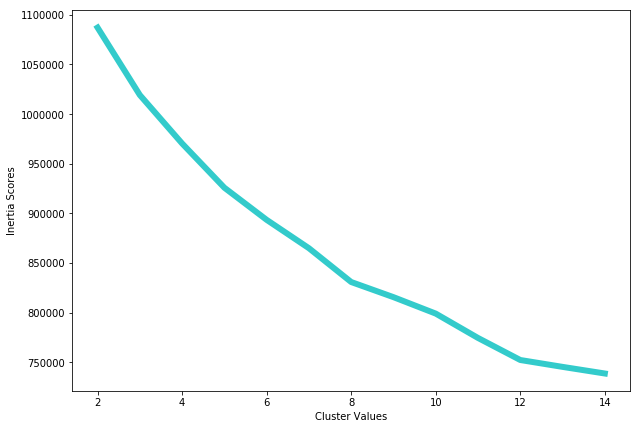

In [179]:
#Plot clusters versus scores
plt.figure(figsize=(10, 7))
plt.plot(cluster_range, i_scores, linewidth = 6, alpha = .8, c = "c")
plt.xlabel("Cluster Values")
plt.ylabel("Inertia Scores");

In [181]:
result.to_csv("lcdf_cluster.csv")

In [180]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183660 entries, 1 to 421094
Data columns (total 84 columns):
num_tl_120dpd_2m              183660 non-null float64
mo_sin_old_il_acct            183660 non-null float64
percent_bc_gt_75              183660 non-null float64
bc_util                       183660 non-null float64
bc_open_to_buy                183660 non-null float64
dti                           183660 non-null float64
num_rev_accts                 183660 non-null float64
delinq_2yrs                   183660 non-null int64
inq_last_6mths                183660 non-null int64
revol_bal                     183660 non-null int64
open_acc                      183660 non-null int64
pub_rec                       183660 non-null int64
total_acc                     183660 non-null int64
num_bc_tl                     183660 non-null int64
funded_amnt                   183660 non-null int64
int_rate                      183660 non-null float64
installment                   183660 non-

In [184]:
result.head(20)

,num_tl_120dpd_2m,mo_sin_old_il_acct,percent_bc_gt_75,bc_util,bc_open_to_buy,dti,num_rev_accts,delinq_2yrs,inq_last_6mths,revol_bal,...,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,ownership_own,ownership_rent,cluster
1,0.0,183.0,0.0,28.1,15310.0,30.84,8.0,0,2,6118,...,0,0,0,0,0,1,0,0,1,1
7,0.0,114.0,25.0,45.9,18383.0,21.77,21.0,0,0,31682,...,0,0,0,0,0,0,0,0,0,2
9,0.0,186.0,50.0,26.8,4319.0,12.14,17.0,0,0,1581,...,0,0,0,0,0,0,0,0,1,3
10,0.0,159.0,85.7,94.9,1106.0,20.43,12.0,0,0,20594,...,0,0,0,0,0,0,0,1,0,2
15,0.0,93.0,63.6,68.9,9044.0,20.84,16.0,0,0,24799,...,0,0,0,0,0,0,0,0,0,1
17,0.0,90.0,0.0,35.6,12808.0,34.85,17.0,0,1,8799,...,0,0,0,0,0,0,0,1,0,1
22,0.0,113.0,7.7,27.1,57830.0,16.06,27.0,1,4,21470,...,0,0,0,0,0,0,0,0,0,1
27,0.0,104.0,100.0,90.2,433.0,9.44,11.0,0,0,6959,...,0,0,0,0,0,0,0,0,0,2
28,0.0,177.0,50.0,38.0,12642.0,25.65,21.0,0,1,7758,...,1,0,0,0,0,0,0,0,0,2
29,0.0,151.0,100.0,88.2,884.0,13.09,18.0,0,2,17771,...,0,0,0,0,1,0,0,1,0,2
